## Set operations with overlay
When working with multiple spatial datasets – especially multiple polygon or line datasets – users often wish to create new shapes based on places where those datasets overlap (or don’t overlap). These manipulations are often referred using the language of sets – intersections, unions, and differences. These types of operations are made available in the GeoPandas library through the [`overlay()`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.overlay.html#geopandas.GeoDataFrame.overlay) method.

The basic idea is demonstrated by the graphic below but keep in mind that overlays operate at the DataFrame level, not on individual geometries, and the properties from both are retained. In effect, for every shape in the left [`GeoDataFrame`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html#geopandas.GeoDataFrame), this operation is executed against every other shape in the right [`GeoDataFrame`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html#geopandas.GeoDataFrame):

![OO](./images/overlay_operations.png)
Source: QGIS documentation

> Note to users familiar with the shapely library: [`overlay()`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.overlay.html#geopandas.GeoDataFrame.overlay) can be thought of as offering versions of the standard shapely set operations that deal with the complexities of applying set operations to two GeoSeries. The standard shapely set operations are also available as [`GeoSeries`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.html#geopandas.GeoSeries) methods.

### The different overlay operations
First, create some example data:

In [2]:
from shapely.geometry import Polygon
import geopandas

In [3]:
polys1 = geopandas.GeoSeries([Polygon([(0,0), (2,0), (2,2), (0,2)]),
                              Polygon([(2,2), (4,2), (4,4), (2,4)])])

polys2 = geopandas.GeoSeries([Polygon([(1,1), (3,1), (3,3), (1,3)]),
                              Polygon([(3,3), (5,3), (5,5), (3,5)])])

<Axes: >

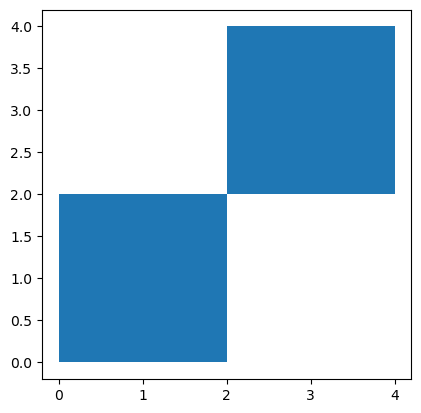

In [5]:
polys1.plot()

<Axes: >

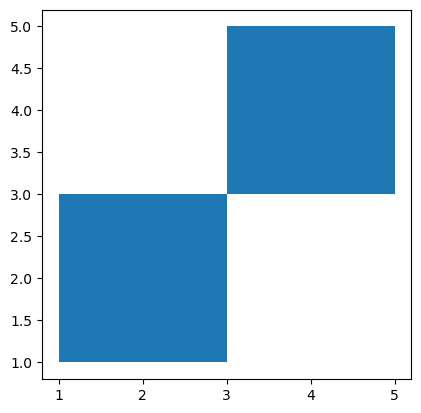

In [6]:
polys2.plot()

In [8]:
df1 = geopandas.GeoDataFrame({'geometry': polys1, 'df1': [1, 2]})
df2 = geopandas.GeoDataFrame({'geometry': polys2, 'df2': [1, 2]})
df1

,geometry,df1
0,"POLYGON ((0.00000 0.00000, 2.00000 0.00000, 2....",1
1,"POLYGON ((2.00000 2.00000, 4.00000 2.00000, 4....",2


<Axes: >

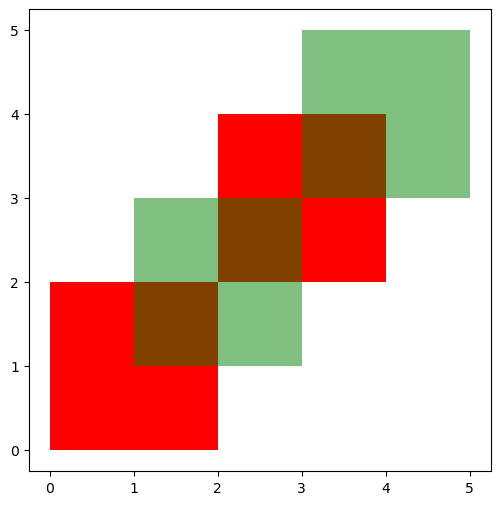

In [14]:
ax = df1.plot(color='red', figsize=(14, 6))
df2.plot(ax=ax, color='green', alpha=0.5)

The above example illustrates the different overlay modes. The [`overlay()`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.overlay.html#geopandas.GeoDataFrame.overlay) method will determine the set of all individual geometries from overlaying the two input GeoDataFrames. This result covers the area covered by the two input GeoDataFrames, and also preserves all unique regions defined by the combined boundaries of the two GeoDataFrames.

> For historical reasons, the overlay method is also available as a top-level function [`overlay()`](https://geopandas.org/en/stable/docs/reference/api/geopandas.overlay.html#geopandas.overlay). It is recommended to use the method as the function may be deprecated in the future.

When using *`how='union'`*, all those possible geometries are returned:

In [15]:
res_union = df1.overlay(df2, how='union')
res_union

,df1,df2,geometry
0,1.0,1.0,"POLYGON ((2.00000 2.00000, 2.00000 1.00000, 1...."
1,2.0,1.0,"POLYGON ((2.00000 2.00000, 2.00000 3.00000, 3...."
2,2.0,2.0,"POLYGON ((4.00000 4.00000, 4.00000 3.00000, 3...."
3,1.0,NaN,"POLYGON ((2.00000 0.00000, 0.00000 0.00000, 0...."
4,2.0,NaN,"MULTIPOLYGON (((3.00000 4.00000, 3.00000 3.000..."
5,NaN,1.0,"MULTIPOLYGON (((2.00000 3.00000, 2.00000 2.000..."
6,NaN,2.0,"POLYGON ((3.00000 5.00000, 5.00000 5.00000, 5...."


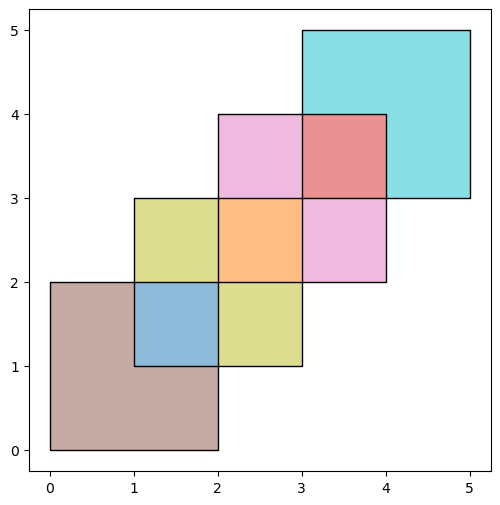

In [18]:
ax = res_union.plot(alpha=0.5, cmap='tab10', figsize=(12, 6))
df1.plot(ax=ax, facecolor='none', edgecolor='k');
df2.plot(ax=ax, facecolor='none', edgecolor='k');

The other *`how`* operations will return different subsets of those geometries. With *`how='intersection'`*, it returns only those geometries that are contained by both GeoDataFrames:

In [19]:
res_intersection = df1.overlay(df2, how='intersection')
res_intersection

,df1,df2,geometry
0,1,1,"POLYGON ((2.00000 2.00000, 2.00000 1.00000, 1...."
1,2,1,"POLYGON ((2.00000 2.00000, 2.00000 3.00000, 3...."
2,2,2,"POLYGON ((4.00000 4.00000, 4.00000 3.00000, 3...."


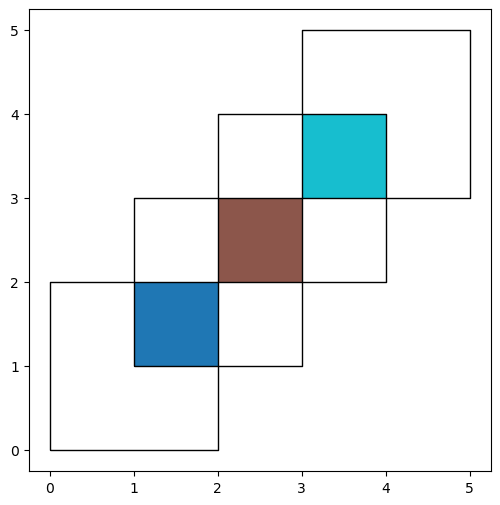

In [20]:
ax = res_intersection.plot(cmap='tab10', figsize=(12, 6))
df1.plot(ax=ax, facecolor='none', edgecolor='k');
df2.plot(ax=ax, facecolor='none', edgecolor='k');

*`how='symmetric_difference'`* is the opposite of *`'intersection'`* and returns the geometries that are only part of one of the GeoDataFrames but not of both:

In [21]:
res_symdiff = df1.overlay(df2, how='symmetric_difference')
res_symdiff

,df1,df2,geometry
0,1.0,NaN,"POLYGON ((2.00000 0.00000, 0.00000 0.00000, 0...."
1,2.0,NaN,"MULTIPOLYGON (((3.00000 4.00000, 3.00000 3.000..."
2,NaN,1.0,"MULTIPOLYGON (((2.00000 3.00000, 2.00000 2.000..."
3,NaN,2.0,"POLYGON ((3.00000 5.00000, 5.00000 5.00000, 5...."


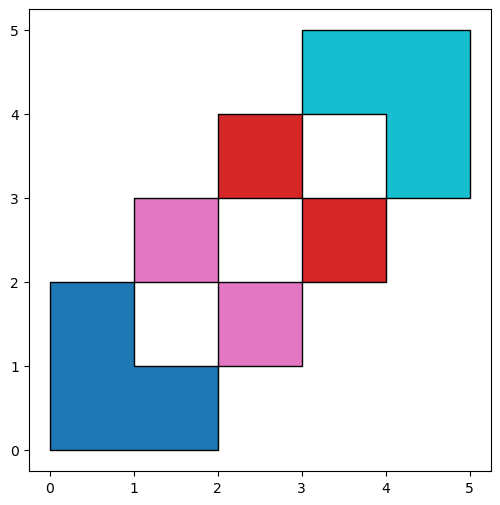

In [22]:
ax = res_symdiff.plot(cmap='tab10', figsize=(12, 6))
df1.plot(ax=ax, facecolor='none', edgecolor='k');
df2.plot(ax=ax, facecolor='none', edgecolor='k');

To obtain the geometries that are part of *`df1`* but are not contained in *`df2`*, you can use *`how='difference'`*:

In [23]:
res_difference = df1.overlay(df2, how='difference')
res_difference

,geometry,df1
0,"POLYGON ((2.00000 0.00000, 0.00000 0.00000, 0....",1
1,"MULTIPOLYGON (((3.00000 4.00000, 3.00000 3.000...",2


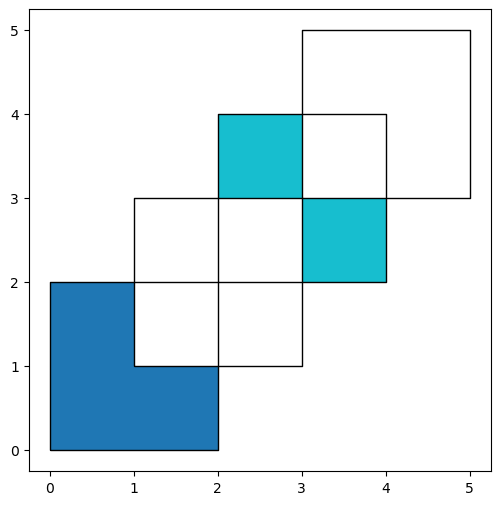

In [24]:
ax = res_difference.plot(cmap='tab10', figsize=(12, 6))
df1.plot(ax=ax, facecolor='none', edgecolor='k');
df2.plot(ax=ax, facecolor='none', edgecolor='k');

Finally, with *`how='identity'`*, the result consists of the surface of *`df1`*, but with the geometries obtained from overlaying *`df1`* with *`df2`*:

In [25]:
res_identity = df1.overlay(df2, how='identity')
res_identity

,df1,df2,geometry
0,1.0,1.0,"POLYGON ((2.00000 2.00000, 2.00000 1.00000, 1...."
1,2.0,1.0,"POLYGON ((2.00000 2.00000, 2.00000 3.00000, 3...."
2,2.0,2.0,"POLYGON ((4.00000 4.00000, 4.00000 3.00000, 3...."
3,1.0,NaN,"POLYGON ((2.00000 0.00000, 0.00000 0.00000, 0...."
4,2.0,NaN,"MULTIPOLYGON (((3.00000 4.00000, 3.00000 3.000..."


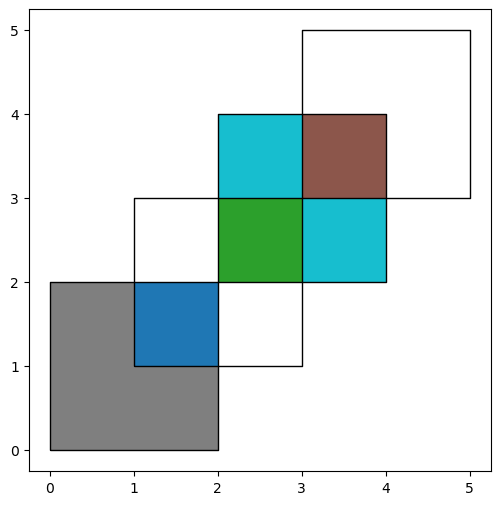

In [26]:
ax = res_identity.plot(cmap='tab10', figsize=(12, 6))
df1.plot(ax=ax, facecolor='none', edgecolor='k');
df2.plot(ax=ax, facecolor='none', edgecolor='k');

### Overlay groceries example
First, load the Chicago community areas and groceries example datasets and select :

In [27]:
import geodatasets

In [28]:
chicago = geopandas.read_file(geodatasets.get_path("geoda.chicago_commpop"))
groceries = geopandas.read_file(geodatasets.get_path("geoda.groceries"))

# Project to crs that uses meters as distance measure
chicago = chicago.to_crs("ESRI:102003")
groceries = groceries.to_crs("ESRI:102003")

To illustrate the [`overlay()`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.overlay.html#geopandas.GeoDataFrame.overlay) method, consider the following case in which one wishes to identify the “served” portion of each area – defined as areas within 1km of a grocery store – using a *`GeoDataFrame`* of community areas and a *`GeoDataFrame`* of groceries.

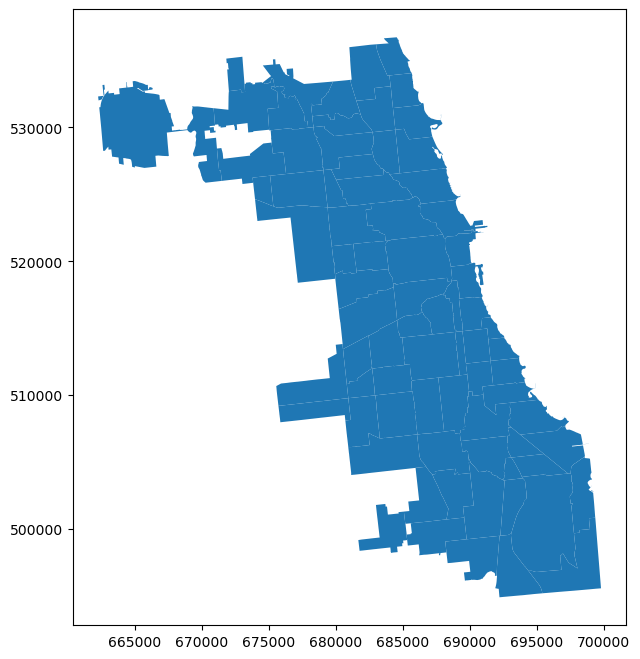

In [33]:
# Look at Chicago:
chicago.plot(figsize=(16, 8));

In [34]:
# Now buffer groceries to find area within 1km.
# Check CRS -- USA Contiguous Albers Equal Area, units of meters.
groceries.crs

<Projected CRS: ESRI:102003>
Name: USA_Contiguous_Albers_Equal_Area_Conic
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United States (USA) - CONUS onshore - Alabama; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming.
- bounds: (-124.79, 24.41, -66.91, 49.38)
Coordinate Operation:
- name: USA_Contiguous_Albers_Equal_Area_Conic
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

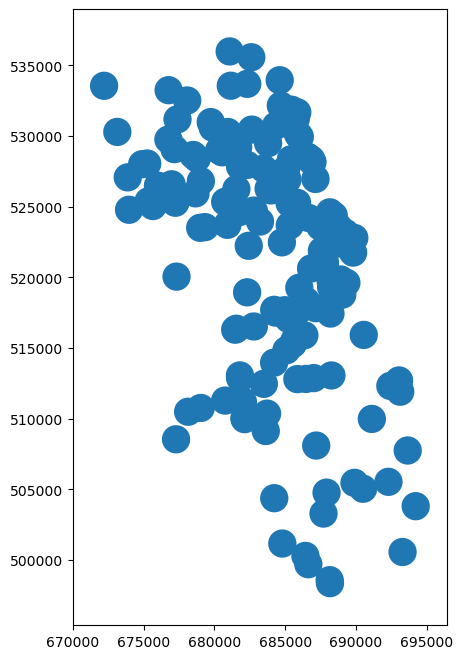

In [35]:
# make 1km buffer
groceries['geometry'] = groceries.buffer(1000)
groceries.plot(figsize=(16, 8));

To select only the portion of community areas within 1km of a grocery, specify the *`how`* option to be “intersect”, which creates a new set of polygons where these two layers overlap:

In [38]:
chicago_cores = chicago.overlay(groceries, how='intersection')
chicago_cores.head()

,community,NID,POP2010,POP2000,POPCH,POPPERCH,popplus,popneg,OBJECTID,Ycoord,Xcoord,Status,Address,Chain,Category,geometry
0,DOUGLAS,35,18238,26470,-8232,-31.099358,0,1,369,41.832885,-87.623453,OPEN,"443 E 34TH ST, CHICAGO, IL. 60616-4135",JEWEL OSCO,None,"POLYGON ((691128.027 516725.732, 691138.907 51..."
1,OAKLAND,36,5918,6110,-192,-3.142390,0,1,369,41.832885,-87.623453,OPEN,"443 E 34TH ST, CHICAGO, IL. 60616-4135",JEWEL OSCO,None,"POLYGON ((690850.265 515037.508, 690855.602 51..."
2,FULLER PARK,37,2876,3420,-544,-15.906433,0,1,382,41.809937,-87.645572,OPEN,"4640 S HALSTED ST, CHICAGO, IL. 60609",FAIRPLAY FINER FOODS,None,"POLYGON ((689124.605 512624.721, 689119.050 51..."
3,GRAND BOULEVARD,38,21929,28006,-6077,-21.698922,0,1,58,41.799463,-87.596114,OPEN,"1226 E 53RD ST, CHICAGO, IL. 60615-4008",HYDE PARK PRODUCE LMT,confirmed,"POLYGON ((691541.704 512767.014, 691552.342 51..."
4,KENWOOD,39,17841,18363,-522,-2.842673,0,1,58,41.799463,-87.596114,OPEN,"1226 E 53RD ST, CHICAGO, IL. 60615-4008",HYDE PARK PRODUCE LMT,confirmed,"POLYGON ((693328.829 512749.585, 693324.227 51..."


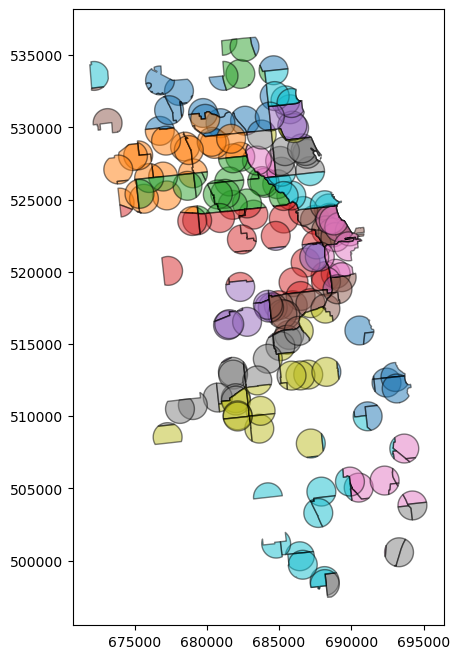

In [39]:
chicago_cores.plot(alpha=0.5, edgecolor='k', cmap='tab10', figsize=(16, 8));

Changing the *`how`* option allows for different types of overlay operations. For example, if you were interested in the portions of Chicago far from groceries (the peripheries), you would compute the difference of the two.

In [40]:
chicago_peripheries = chicago.overlay(groceries, how='difference')
chicago_peripheries.head()

,community,NID,POP2010,POP2000,POPCH,POPPERCH,popplus,popneg,geometry
0,DOUGLAS,35,18238,26470,-8232,-31.099358,0,1,"MULTIPOLYGON (((690919.436 517269.986, 690919...."
1,OAKLAND,36,5918,6110,-192,-3.142390,0,1,"POLYGON ((692576.658 514302.192, 692364.291 51..."
2,FULLER PARK,37,2876,3420,-544,-15.906433,0,1,"POLYGON ((689728.288 512345.788, 689729.803 51..."
3,GRAND BOULEVARD,38,21929,28006,-6077,-21.698922,0,1,"POLYGON ((691397.306 514158.017, 691400.055 51..."
4,KENWOOD,39,17841,18363,-522,-2.842673,0,1,"POLYGON ((692594.581 514260.387, 692596.773 51..."


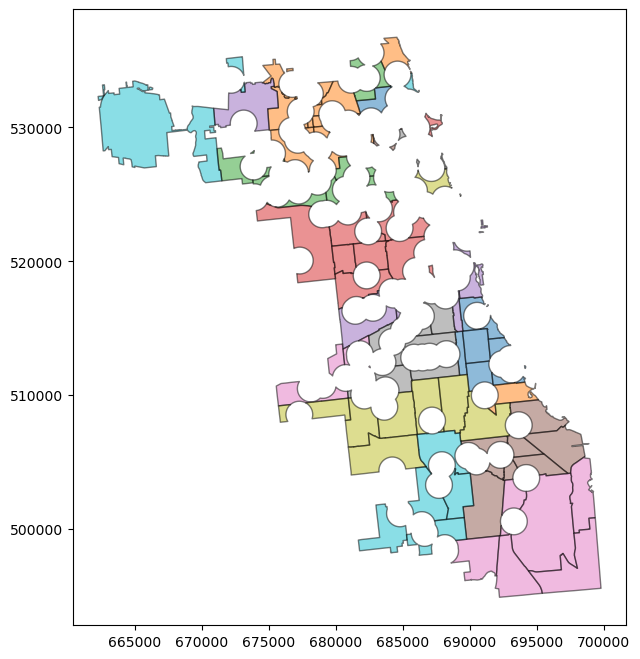

In [41]:
chicago_peripheries.plot(alpha=0.5, edgecolor='k', cmap='tab10', figsize=(16, 8));

### keep_geom_type keyword
In default settings, [`overlay()`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.overlay.html#geopandas.GeoDataFrame.overlay) returns only geometries of the same geometry type as GeoDataFrame (left one) has, where Polygon and MultiPolygon is considered as a same type (other types likewise). You can control this behavior using *`keep_geom_type`* option, which is set to True by default. Once set to False, *`overlay`* will return all geometry types resulting from selected set-operation. Different types can result for example from intersection of touching geometries, where two polygons intersects in a line or a point.

### More examples
A larger set of examples of the use of [`overlay()`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.overlay.html#geopandas.GeoDataFrame.overlay) can be found [here](https://nbviewer.jupyter.org/github/geopandas/geopandas/blob/main/doc/source/gallery/overlays.ipynb)